# cleanup data and store for latter processing

To do:

- add wind information:
    - [ ] wind station (got it but need to be processed)
- go get tide information (currents, sea level):
    - [ ] SMILE ADCP data (waiting
- satellite data: S2, SST
    - [ ] ask
    - [ ] process
    

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import cmocean.cm as cm

import numpy as np
import pandas as pd
import xarray as xr

# 
import pynsitu as pin
from pynsitu.maps import crs
import taos.sensors as se

/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/pyTMD/tools.py:55: UserWarning: ipyleaflet not available
  warnings.warn("ipyleaflet not available")
/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/pyTMD/tools.py:56: UserWarning: Some functions will throw an exception if called
  warnings.warn("Some functions will throw an exception if called")


In [2]:
## taos
root_dir = "/Users/aponte/Current_Projects/taos/campagnes/taos0/"

# taos0-drifters0
campaign="taos0_drifters0"
yaml = f"drifters0/{campaign}.yaml"

# taos0-drifters1
#campaign="taos0_drifters1"
#yaml = f"drifters1/{campaign}.yaml"

cp = pin.Campaign(os.path.join(root_dir,yaml))



In [3]:
def read_sonde_lern(file, tz_offset=0, stype=0):
    """ Load LERN CTD data
    """
    
    with open(file, encoding="unicode_escape") as f:
        d = list(f.readlines())

    # replace NUL, strip whitespace from the end of the strings, split each string into a list
    d = [v.replace('\x00', '').strip().replace(",",".").split('\t') for v in d]

    # remove some empty rows
    d = [v for v in d if len(v) > 1]
    
    #d[0]:
    #['Date', 'Time', 'Site', 'Unit ID', 'User ID',
    # '°C-19K104425', 'mmHg-19C102825', 'DO %-20A103151', 'DO mg/L-20A103151', 
    # 'C-mS/cm-19K104425', 'SAL-PSU-19K104425', 'FNU-19M102353',
    # 'Chl RFU-19M101982', 'Chl ug/L-19M101982',
    # 'DEP m-19K105267']

    # benji deployments
    # ['Date', 'Time', 'Site', 'Unit ID', 'User ID', 
    # '°C-21A101173', 'mmHg-20L100404', 'DO %-21A100555', 'DO mg/L-21A100555', 
    # 'C-mS/cm-21A101173', 'SAL-PSU-21A101173', 
    # 'DEP m-20H100561']

    if stype==0:
        columns = ['Date', 'Time', 'Site', 'Unit ID', 'User ID',
         'temperature', 'air_pressure', 'DO_p', 'DO_mgL', 
         'conductivity', 'salinity', 'FNU',
         'Chl_RFU', 'Chl_ugL',
         'depth', 'latitude', 'longitude']
    elif stype==1:
        columns = ['Date', 'Time', 'Site', 'Unit ID', 'User ID',
         'temperature', 'air_pressure', 'DO_p', 'DO_mgL', 
         'conductivity', 'salinity',
         'depth', 'latitude', 'longitude']

    df = pd.DataFrame(d[1:], columns=columns)
    
    # convert column 0 and 1 to a datetime
    df['time'] = pd.to_datetime(df["Date"] + ' ' + df["Time"]) + pd.Timedelta("1H")*tz_offset

    df.set_index("time", inplace=True)
    df = df.drop(columns=["Date", "Time", "Site", "Unit ID", "User ID"])

    df = df.astype('float')

    # convert air pressure from mmHg to bar
    df["air_pressure"] = df["air_pressure"]/750.06
    
    # bad longitude, latitude values are 0.0
    df.loc[:, "longitude"] = df.loc[:, "longitude"].where(df.loc[:, "longitude"] != 0.)
    df.loc[:, "latitude"] = df.loc[:, "latitude"].where(df.loc[:, "latitude"] != 0.)

    return df

In [4]:
p, s, stype = "parceque", "ctd", 0 # franck - check
#p, s, stype = "hydrophone", "ctd", 1 # benji
despike=False

case=0

if p=="parceque":
    # parceque 

    if case==0:
        # taos0-drifters0, day 0
        assert campaign=="taos0_drifters0", "campaign should be taos0_drifters0"
        ctd_path = os.path.join(cp["path_raw"], s+"_"+p+"_11052022.csv")
        labels = [f"u{i}" for i in range(4)]
        despike=True
    elif case==1:
        # taos0-drifters0, day 1
        assert campaign=="taos0_drifters0", "campaign should be taos0_drifters0"
        ctd_path = os.path.join(cp["path_raw"], s+"_"+p+"_13052022.csv")
        labels = ["u4", "c5", "c6"]
    elif case==2:
        # taos0-drifters1, day 0
        assert campaign=="taos0_drifters1", "campaign should be taos0_drifters1"
        ctd_path = os.path.join(cp["path_raw"], s+"_"+p+"_17052022.csv")
        labels = ["u0"]
    elif case==3:
        # taos0-drifters1, day 1
        assert campaign=="taos0_drifters1", "campaign should be taos0_drifters"
        ctd_path = os.path.join(cp["path_raw"], s+"_"+p+"_19052022.csv")
        labels = ["u1"]

elif p == "hydrophone":
    # hydrophone
    
    if case==0:
        raise AttributeError("not a valid case")
        # taos0-drifters0, day 0  !!! no valid CTD
    elif case==1:
        raise AttributeError("not a valid case")
        # taos0-drifters0, day 1  !!! no valid CTD
    elif case==2:
        # taos0-drifters1, day 0
        ctd_path = os.path.join(cp["path_raw"], s+"_"+p+"_17052022.csv")
        labels = [f"c{i}" for i in range(15)]
    elif case==3:
        # taos0-drifters1, day 1
        ctd_path = os.path.join(cp["path_raw"], s+"_"+p+"_19052022.csv")
        labels = [f"c{i}" for i in range(15,23)]


In [5]:
df = read_sonde_lern(ctd_path, tz_offset=-2, stype=stype)

# rule=None -> raw data
df.sw.plot_bokeh(deployments=cp[p][s], cross=False)

some values of longitude and latitudes are NaN, you may want to fill in with correct values


Loading BokehJS ...

### plot raw salinity and diff to identify spikes

May be skipped if data is known not to have noisy salinity

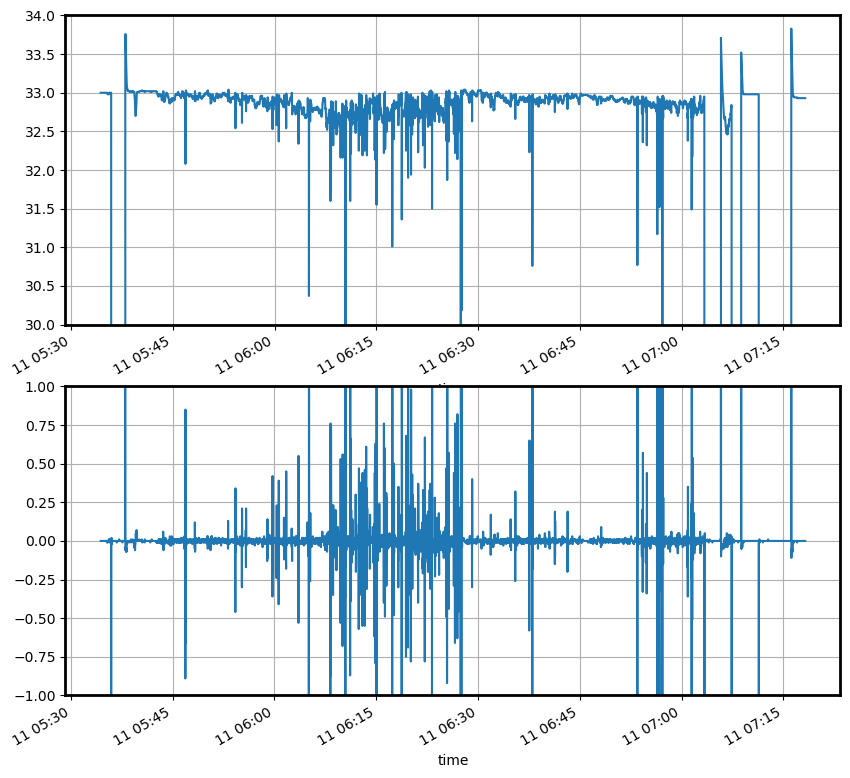

In [6]:
def plot_salinity(df, **kwargs):

    fig, axes = plt.subplots(2,1, figsize=(10,10))
    ax = axes[0]
    df.salinity.plot(ax=ax, **kwargs)
    ax.grid()
    ax.set_ylim([30,34])

    ax = axes[1]
    df.salinity.diff().plot(ax=ax, **kwargs)
    ax.grid()
    ax.set_ylim([-1,1])

plot_salinity(df)

fractions of salinity difference (with smoothed salinity) lower than 0.2 psu = 96.7%


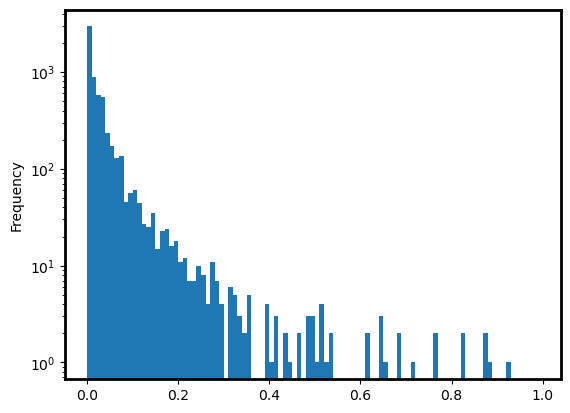

In [7]:
# salinity smoothing
rule = "10s" # 20s at 2m/s is 40m
dsalinity_threshold = 0.2

fig, ax = plt.subplots(1,1)
dfs = df.rolling(window=rule).median()
ds = df.salinity-dfs.salinity
np.abs(ds).plot.hist(bins=np.arange(0,1,.01), ax=ax)
ax.set_yscale("log")

_frac = (ds.loc[np.abs(ds)<dsalinity_threshold].index.size / ds.index.size)
print(f"fractions of salinity difference (with smoothed salinity) lower than {dsalinity_threshold} psu = {_frac*100:.1f}%")

### plot one cast time series

Search to highlight casts quality

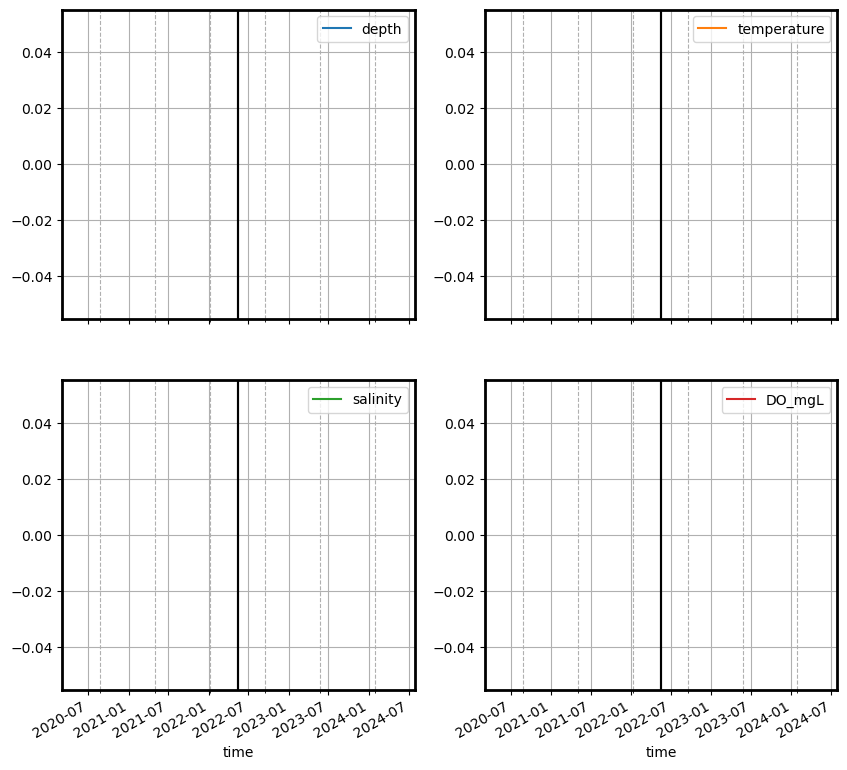

In [21]:
if p=="hydrophone":

    _df = df.loc["2022-05-17 08:50:00":"2022-05-17 08:55:00"]
    d = cp["hydrophone"]["ctd"]["c6"]

    _df = _df.loc[:,["depth", "temperature", "salinity", "DO_mgL"]]
    _df["salinity"] = _df["salinity"].where(_df["salinity"]>30)

    axes = _df.plot(subplots=True, figsize=(10,10), grid=True, layout=(2,2))
    for ax in axes.flatten():
        ax.grid(which='minor', axis='both', linestyle='--')
        ax.axvline(d.start.time, color="k")
        ax.axvline(d.end.time, color="k")

---

## observed and modelled sea level and tidal currents

In [ ]:
import taos.utils as ut
dsh = ut.predict_tides(_ds.date_start, real=False, summed=False)

----

## wind, arome

To be done on datarmor.
Copy extracted netcdf file back on laptop.


In [2]:
import xarray as xr
import pandas as pd
from glob import glob

In [3]:
arome_dir = "/home/ref-oc-intranet-restricted/modeles_mf/arome_v2/best_estimate/"


def load_arome(t, dt=None, freq="1H", rkwargs={}, **kwargs):
    """ Extract ERA data
    https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5
    
    Parameters
    ----------
    t: date-like object
        date for extraction
    dt: tuple, optional
        time interval in days around t
    freq: str
        frequency of outputs selected, e.g. "1H" or "1D"
    rkwargs: dict
        passed to load_dataset
    **kwargs: passed for direct selection
    """
    
    t = pd.to_datetime(t)
    if dt is not None:
        t = [t+pd.Timedelta(days=_dt) for _dt in range(*dt)]
        t = pd.date_range(t[0],t[-1], freq=freq)
    else:
        t = [t]
    
    #
    D = []
    for _t in t:
        _rpath = f"{_t.year}/METEOFRANCE_AROME_{_t.year}{_t.month:02d}{_t.day:02d}T{_t.hour:02d}Z*.nc"
        files = glob(os.path.join(arome_dir, _rpath)) 
        _ds = xr.merge([xr.load_dataset(f, **rkwargs).squeeze().sel(**kwargs) for f in files])
        D.append(_ds)
    ds = xr.concat(D, dim="time")

    return ds

In [4]:
# taos0-drifters0
t = pd.Timestamp(2022,5,12)
label = "taos0-drifters0"

# taos0-drifters1
t = pd.Timestamp(2022,5,19)
label = "taos0-drifters1"

ds = load_arome(t, dt=(-30,5,), longitude=slice(-2,2), latitude=slice(48,50)).chunk(dict(time="auto"))

nc = os.path.join(os.getenv("SCRATCH"), label+"_arome.nc")
ds.to_netcdf(nc, mode="w")

### quick overview

In [11]:
ds = cp.load("arome.nc")

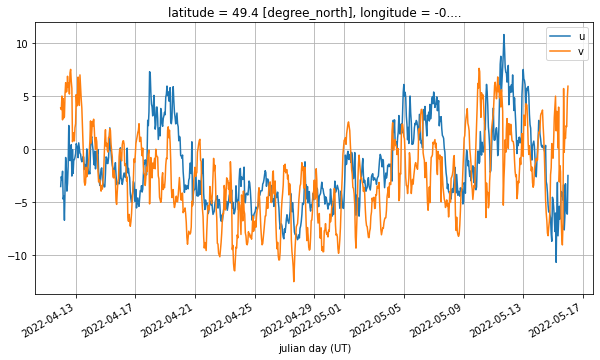

In [13]:
_ds = ds.sel(longitude=-0.2, latitude=49.4, method="nearest")

fig, ax = plt.subplots(1,1, figsize=(10,5))
_ds.u10m.plot(label="u")
_ds.v10m.plot(label="v")
ax.grid()
ax.set_ylabel("")
ax.legend()

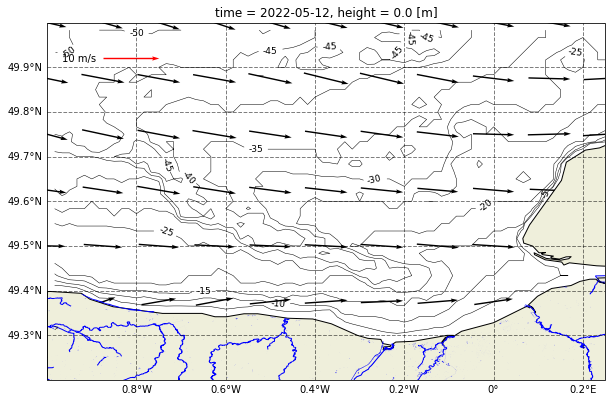

In [42]:
bounds=[-.5, -.1, 49.25, 49.5]
bounds=[-1., .25, 49.2, 50.]
fig, ax, cbar = cp.map(bounds=bounds, coast="bseine", land=None, rivers="bseine")

di=5
_ds = (ds.sel(time="2022-05-12 00:00:00")
       .isel(longitude=slice(0,None,di),latitude=slice(0,None,di))
      )

q = _ds.plot.quiver(x="longitude", y="latitude", u="u10m", v="v10m", scale=1e2, transform=crs, zorder=-2)
qk = ax.quiverkey(q, 0.1, 0.9, 10, '10 m/s', transform=crs, color="r",
                  labelpos='W', coordinates='axes', zorder=10)

---

## river discharges

---

## tides, sea level/currents



In [3]:
tgauge_dir = "/Users/aponte/Data/tides/maregraphe"

In [4]:
from glob import glob
tgauge_files = sorted(glob(os.path.join(tgauge_dir, "*.nc")))

ds = xr.open_dataset(tgauge_files[-1])

ds = ds.rename(dict(TIME="time", 
                    LATITUDE="latitude", LONGITUDE="longitude",
                    Source1="sea_level",
                   )
              )

# demean sea level
ds["sea_level"] = ds["sea_level"] - ds["sea_level"].mean("time")

In [5]:
dt = (ds.time.diff("time")/pd.Timedelta("1s"))
print(f" min(dt)= {float(dt.min())} max(dt)= {float(dt.max())} ")

 min(dt)= 60.0 max(dt)= 10106.0 


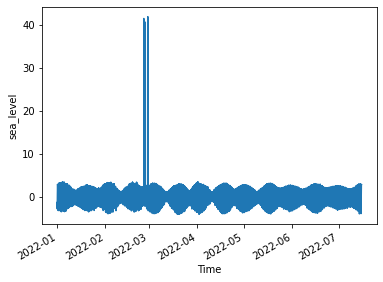

In [6]:
ds.sea_level.plot()

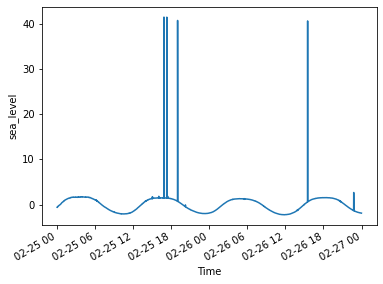

In [57]:
ds.sel(time=slice("2022-02-25","2022-02-26")).sea_level.plot()

In [43]:
#dsr = ds.sel(time=slice(cp.start - pd.Timedelta("10D"), cp.end + pd.Timedelta("10D"))).resample(time="10T").mean()
dsr = ds.sel(time="2022").resample(time="10T").mean()


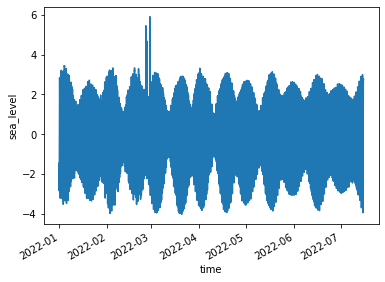

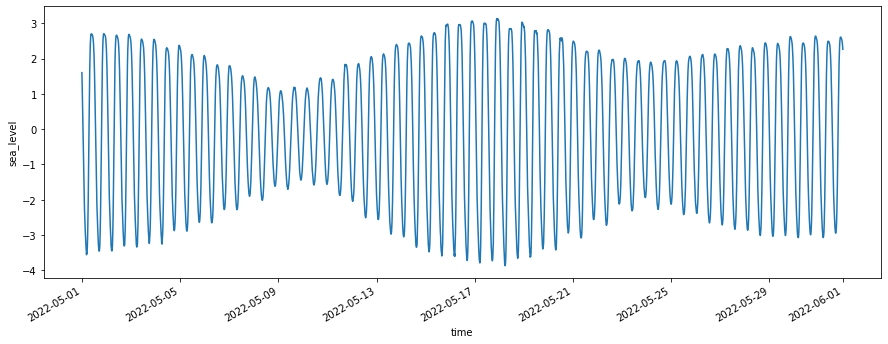

In [44]:
dsr.sea_level.sel(time="2022-05").plot(figsize=(15,5))

/var/folders/pb/vp119fcj1pn3dc3x2dz4dkt80000gn/T/ipykernel_13691/2428150208.py:4: UserWarning: registration of accessor <class '__main__.TimeSeriesAccessor'> under name 'ts' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  class TimeSeriesAccessor:


In [45]:
df = dsr.to_dataframe()
df.ts.time_physical()
df.head()

latitude  longitude  sea_level        timep
time                                                             
2022-01-01 00:00:00  49.279362   -0.24903  -1.461973  378691200.0
2022-01-01 00:10:00  49.279362   -0.24903  -1.644713  378691800.0
2022-01-01 00:20:00  49.279362   -0.24903  -1.793523  378692400.0
2022-01-01 00:30:00  49.279362   -0.24903  -1.939423  378693000.0
2022-01-01 00:40:00  49.279362   -0.24903  -2.078783  378693600.0

['M2', 'K1', 'S2', 'O1', 'P1', 'N2', 'K2', 'Q1', 'J1', 'L2', 'T2', '2N2', 'MN4', 'M4', 'MS4', 'M6', 'M3', 'R2', 'S1', 'S4', 'MKS2', 'N4', 'M8']


/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/matplotlib/text.py:830: ComplexWarning: Casting complex values to real discards the imaginary part
  x = float(self.convert_xunits(self._x))
/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/matplotlib/text.py:690: ComplexWarning: Casting complex values to real discards the imaginary part
  posx = float(self.convert_xunits(self._x))


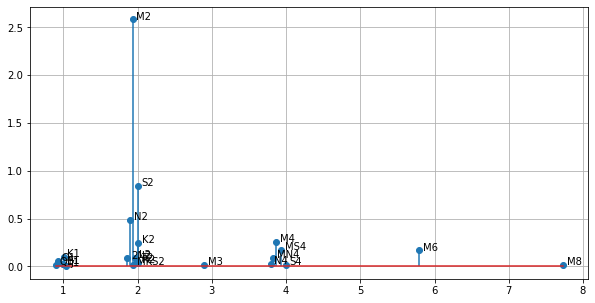

In [46]:
cst = ["O1", "K1", "M2", "S2"]

c = load_equilibrium_constituents()
cst = [c.upper() for c in list(c.sort_values("amplitude", ascending=False)
                               .iloc[:].index
                              )
      ]
cst = [c for c in cst if c not in ["MF", "MM", "SSA", "NU2", "MU2", "EPS2", "MSF", "LAMBDA2", "MSQM", "SA", "MTM"]]
print(cst)

#cst = cst + ["M4", "MS4"]

df.ts.tidal_analysis("sea_level", constituents=cst)

/var/folders/pb/vp119fcj1pn3dc3x2dz4dkt80000gn/T/ipykernel_13691/2428150208.py:220: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  v =  ( f * np.exp(1j*vu) * np.conj(har[:,None]) ).sum(axis=0)


<AxesSubplot:xlabel='time'>

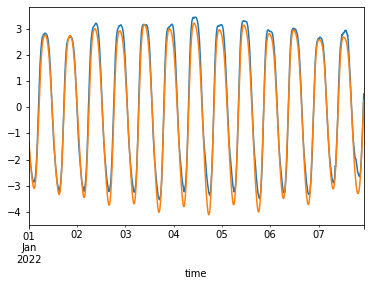

In [47]:
df["sea_level_tide"] = df.ts.tidal_predict("sea_level")

sl = slice(0,1000)
#sl = slice(0,None)

df["sea_level"].iloc[sl].plot()
df["sea_level_tide"].iloc[sl].plot()

In [50]:
# store
dsr.to_netcdf(os.path.join(cp["path_processed"], f'sea_level.nc'), mode="w")

In [ ]:
---

## bouées

In [58]:
b_dir = "/Users/aponte/Current_Projects/taos/campagnes/taos0/drifters1/coriolis"

file = os.path.join(b_dir, "mooring-buoys-time-series-6200310.nc")
ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:                          (N_PROF: 28845, N_PARAM: 17, N_LEVELS: 1, N_CALIB: 1, N_HISTORY: 0)
Dimensions without coordinates: N_PROF, N_PARAM, N_LEVELS, N_CALIB, N_HISTORY
Data variables: (12/148)
    DATA_TYPE                        object ...
    FORMAT_VERSION                   object ...
    HANDBOOK_VERSION                 object ...
    REFERENCE_DATE_TIME              object ...
    DATE_CREATION                    object ...
    DATE_UPDATE                      object ...
    ...                               ...
    HISTORY_ACTION                   (N_HISTORY, N_PROF) object ...
    HISTORY_PARAMETER                (N_HISTORY, N_PROF) object ...
    HISTORY_START_PRES               (N_HISTORY, N_PROF) float32 ...
    HISTORY_STOP_PRES                (N_HISTORY, N_PROF) float32 ...
    HISTORY_PREVIOUS_VALUE           (N_HISTORY, N_PROF) float32 ...
    HISTORY_QCTEST                   (N_HISTORY, N_PROF) object ...
Attributes:
    title:                
    institution:          
    source:               Coriolis
    history:              2022-07-17T20:00:15Z creation
    references:           http://www.argodatamgt.org/Documentation
    comment:              
    user_manual_version:  3.03
    Conventions:          Argo-3.0 CF-1.6
    featureType:          trajectoryProfile

---

## old stuff

In [25]:
file = "sonde_benji_13.csv"
file_path = os.path.join(root_dir, file)
df = read_sonde_lern(file_path, stype=1)

['Date', 'Time', 'Site', 'Unit ID', 'User ID', 'ï¿½C-21A101173', 'mmHg-20L100404', 'DO %-21A100555', 'DO mg/L-21A100555', 'C-mS/cm-21A101173', 'SAL-PSU-21A101173', 'DEP m-20H100561']


array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>], dtype=object)

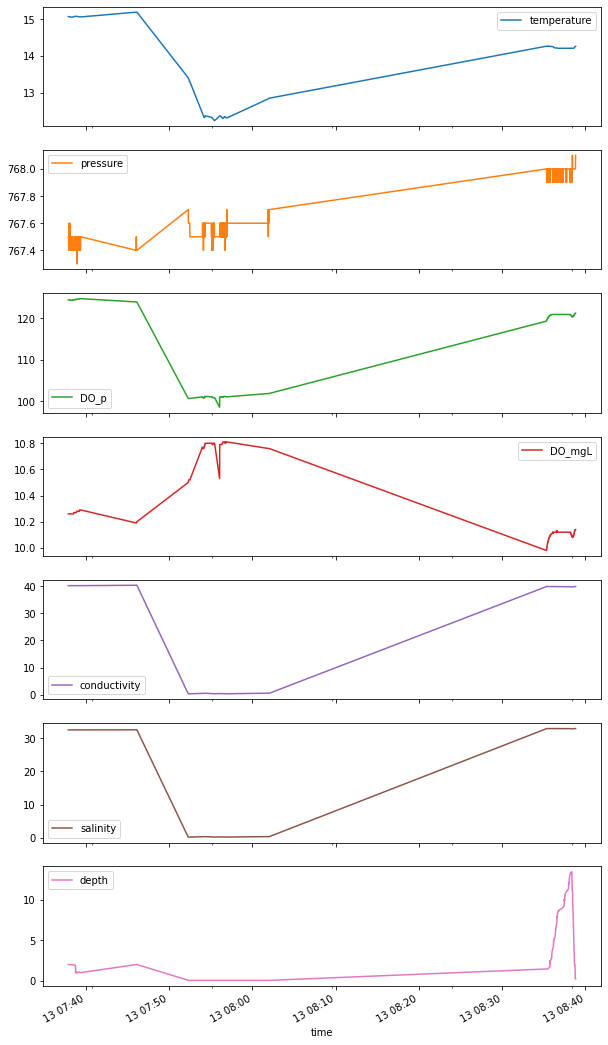

In [26]:
df.plot(subplots=True, figsize=(10,20))